In [19]:
import os
import pandas as pd
import shutil
import yaml
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
from tqdm.notebook import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/coder/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [20]:
def process_split(csv_path, images_dir, output_dir, split, class_map):
    print(f"\n Processing split: {split.upper()}")
    # Load and filter
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    df['class'] = df['class'].str.strip().str.lower()
    df = df[df['class'].isin(class_map.keys())]
    print(f" {len(df)} annotations from {df['filename'].nunique()} images.")
    # Make dirs
    images_split_dir = os.path.join(output_dir, f'images/{split}')
    labels_split_dir = os.path.join(output_dir, f'labels/{split}')
    os.makedirs(images_split_dir, exist_ok=True)
    os.makedirs(labels_split_dir, exist_ok=True)

    for img_name in df['filename'].unique():
        src_img = os.path.join(images_dir, img_name)
        dst_img = os.path.join(images_split_dir, img_name)

        if not os.path.exists(src_img):
            print(f" Image not found: {src_img}")
            continue

        shutil.copy2(src_img, dst_img)
        annots = df[df['filename'] == img_name]
        width, height = annots.iloc[0]['width'], annots.iloc[0]['height']

        yolo_lines = []
        for _, row in annots.iterrows():
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            box_w = (xmax - xmin) / width
            box_h = (ymax - ymin) / height
            class_id = class_map[row['class']]

            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}")

        label_file = os.path.join(labels_split_dir, os.path.splitext(img_name)[0] + ".txt")
        with open(label_file, "w") as f:
             f.write("\n".join(yolo_lines))
             
    print(f" Done with {split.upper()} set.")

In [21]:
def generate_dataset_yaml(output_dir, class_map):
    yaml_dict = {
        "train": os.path.abspath(os.path.join(output_dir, "images/train")),
        "val": os.path.abspath(os.path.join(output_dir, "images/test")),
        "nc": len(class_map),
        "names": list(class_map.keys())
    }
    yaml_path = os.path.join(output_dir, "dataset.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(yaml_dict, f)
    print(f"\n Created dataset.yaml at {yaml_path}")

In [22]:
def visualize_yolo(images_dir, labels_dir, output_dir, class_names):
    print(f"\n Visualizing YOLO bounding boxes...")
    os.makedirs(output_dir, exist_ok=True)
    
    for image_file in os.listdir(images_dir):
        if not image_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, os.path.splitext(image_file)[0] + ".txt")
        
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
        h, w = img.shape[:2]
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, cx, cy, bw, bh = map(float, line.strip().split())
                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)
                    
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, class_names[int(cls)], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        cv2.imwrite(os.path.join(output_dir, image_file), img)
    print(f"Visualization complete. Check the folder: {output_dir}")

In [23]:
def show_sample_with_matplotlib(image_path):
    print(f"\n Showing sample image: {image_path}")
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("YOLO Visualization")
    plt.show()



 Processing split: TRAIN
 10398 annotations from 279 images.
 Done with TRAIN set.

 Processing split: TEST
 2670 annotations from 70 images.
 Done with TEST set.

 Created dataset.yaml at yolo_dataset/dataset.yaml

 Visualizing YOLO bounding boxes...
Visualization complete. Check the folder: yolo_dataset/visualized

 Showing sample image: yolo_dataset/visualized/ck2izo2m00bon0944wqqs7xvi.jpg


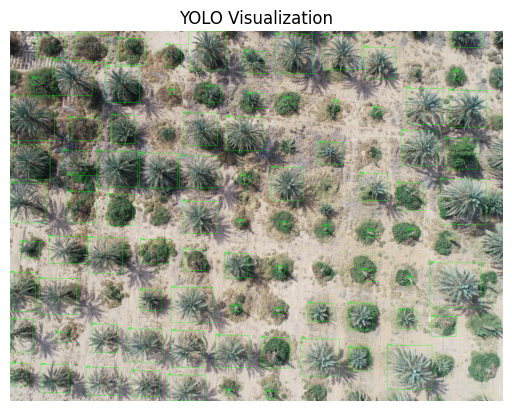

In [24]:
if __name__ == "__main__":
    # === Set your paths ===
    CSV_TRAIN = "project/train_labels.csv"
    CSV_TEST = "project/test_labels.csv"
    IMAGES_DIR = "project/train_mages/train"
    TEST_IMAGES_DIR = "project/test"
    OUTPUT_DIR = "yolo_dataset"

     # === Class label mapping ===
    class_mapping = {'palm': 0, 'tree': 1}
    class_names = ['palm', 'tree']

    # === Process each split ===
    process_split(CSV_TRAIN, IMAGES_DIR, OUTPUT_DIR, "train", class_mapping)
    process_split(CSV_TEST, TEST_IMAGES_DIR, OUTPUT_DIR, "test", class_mapping)

    # === Write dataset.yaml ===
    generate_dataset_yaml(OUTPUT_DIR, class_mapping)

    # Visualize and show with matplotlib
    visualize_dir = os.path.join(OUTPUT_DIR, "visualized")
    visualize_yolo(
        images_dir=os.path.join(OUTPUT_DIR, "images/train"),
        labels_dir=os.path.join(OUTPUT_DIR, "labels/train"),
        output_dir=visualize_dir,
        class_names=class_names
    )
    
    # Show one sample using matplotlib
    sample_path = os.path.join(visualize_dir, "sample.jpg")
    if os.path.exists(sample_path):
        show_sample_with_matplotlib(sample_path)
    else:
        # Just pick any one to display
        files = [f for f in os.listdir(visualize_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if files:
            show_sample_with_matplotlib(os.path.join(visualize_dir, files[0]))
        else:
            print("No visualized image found to display.")




In [26]:
# Load the model (you can change to yolov8s.pt, yolov8m.pt, etc.)
model = YOLO('yolov8n.pt')  # 'n' is the nano version (smallest, fastest)
# Path to your dataset.yaml
DATASET_YAML = 'yolo_dataset/dataset.yaml'
# Train the model with progress shown in notebook
results = model.train(
    data=DATASET_YAML,
    epochs=50,              # Number of epochs
    imgsz=640,              # Image size
    batch=16,               # Batch size (adjust to your GPU/CPU power)
    verbose=True,           # Print logs
)

Ultralytics 8.3.159 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 950M, 4044MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, 

100%|██████████████████████████████████████| 5.35M/5.35M [00:04<00:00, 1.14MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1478.7±1996.4 MB/s, size: 2140.6 KB)


train: Scanning /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/labels/train... 2

train: New cache created: /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 184.3±53.0 MB/s, size: 2394.1 KB)


val: Scanning /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/labels/test... 70 i

val: New cache created: /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/labels/test.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.23G      2.122      3.468      1.665        373        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670     0.0516      0.345       0.12     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.35G      1.586      1.808      1.222        325        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670       0.95      0.305      0.419      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.36G      1.504      1.236      1.153        345        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.656      0.487      0.521      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.34G      1.435      1.042      1.139        433        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.601      0.565      0.562      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.34G      1.416     0.9638      1.138        370        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.584      0.612      0.599      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.34G      1.396     0.9516      1.126        396        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.597      0.611      0.591      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.34G      1.393     0.9391      1.143        227        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.623       0.65      0.637      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.34G      1.364     0.8831       1.13        456        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.681      0.671      0.677      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.34G       1.34     0.8523      1.097        282        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.713       0.67      0.703      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.34G      1.323     0.8332      1.121        357        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.732        0.7      0.742      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.34G      1.333     0.8147      1.106        541        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.709      0.682      0.721      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.34G      1.319     0.7743      1.098        468        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.733      0.694       0.74      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.34G      1.281     0.7569      1.086        428        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.783      0.733      0.777      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.34G      1.298     0.7524      1.098        494        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.739      0.721      0.755      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.34G      1.284     0.7242      1.086        408        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.714      0.772       0.77      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.34G      1.275     0.7106      1.091        474        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.753      0.746      0.775       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.34G      1.287     0.7148      1.081        551        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.758      0.708      0.766      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.34G       1.27     0.7202      1.085        304        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.743      0.743      0.767      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.34G      1.273     0.7196      1.095        316        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.743      0.749      0.781      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.34G      1.264     0.6971      1.066        375        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.786      0.752      0.782      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.34G      1.264     0.6952      1.081        353        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.698      0.732      0.748       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.34G      1.248     0.6678      1.068        289        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.737      0.759      0.764      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.34G      1.276     0.6873       1.08        331        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.742      0.754      0.774      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.34G      1.246     0.6559      1.065        353        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.739      0.771      0.769      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.34G      1.242     0.6638       1.06        440        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.743      0.757      0.769      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.34G      1.263     0.6717      1.067        547        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.773       0.72      0.769      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.34G      1.236     0.6508      1.051        361        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.744      0.752      0.772      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.34G      1.204     0.6466      1.059        522        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.751      0.787      0.781      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.34G      1.216     0.6437      1.057        292        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.787      0.696      0.778      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.34G      1.229     0.6409      1.061        479        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.793      0.787      0.813       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.34G      1.246     0.6616      1.059        485        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.776      0.793       0.81      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.34G      1.223     0.6298      1.061        284        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.779       0.79      0.817      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.34G      1.204     0.6174      1.051        582        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.791      0.799       0.81      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.34G      1.227     0.6329      1.063        286        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.788      0.789      0.814      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.34G      1.229     0.6285      1.066        589        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.789      0.774      0.804      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.34G      1.216     0.6192       1.06        350        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.785      0.783      0.815      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.34G      1.215     0.6297      1.051        565        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.748      0.794      0.801      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.34G      1.196     0.6134      1.056        533        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.806      0.778       0.82      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.34G      1.191     0.6114      1.036        584        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670       0.78      0.795      0.818      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.34G      1.163     0.6019       1.04        550        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.779       0.77      0.787      0.444


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.42G      1.214     0.6512       1.07        258        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.756      0.757      0.759      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.32G      1.184     0.6055      1.062        243        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.757      0.769      0.786      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.39G      1.184      0.597      1.046        233        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.766      0.761      0.779      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.34G      1.167     0.5815      1.047        235        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.761      0.785      0.789       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.42G      1.177     0.5892       1.05        251        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.774      0.783      0.797      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.43G      1.158     0.5752      1.045        227        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.801      0.781      0.813      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.4G      1.151     0.5726      1.042        140        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.784      0.808      0.816      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.34G      1.145     0.5645      1.038        194        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.799      0.793       0.82      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.29G      1.144     0.5696       1.04        154        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.817      0.775      0.819       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.42G      1.145     0.5565      1.045        280        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         70       2670      0.819      0.775      0.819      0.462



50 epochs completed in 0.868 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 950M, 4044MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         70       2670      0.801      0.794      0.821      0.464
                  palm         66       2345      0.936       0.94      0.973      0.614
                  tree         43        325      0.665      0.647       0.67      0.314
Speed: 1.1ms preprocess, 34.5ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/train


# Model Evaluation 

In [27]:
model = YOLO("runs/detect/train/weights/best.pt")  # Path to trained weights
metrics = model.val(data="yolo_dataset/dataset.yaml")
print(metrics)

Ultralytics 8.3.159 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 950M, 4044MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5807.0±487.2 MB/s, size: 2055.5 KB)


val: Scanning /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/labels/test.cache..
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         70       2670      0.798      0.796      0.821      0.464
                  palm         66       2345      0.934      0.943      0.973      0.614
                  tree         43        325      0.663      0.649      0.668      0.314
Speed: 3.2ms preprocess, 23.5ms inference, 0.1ms loss, 19.4ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x77c3d0063f20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     

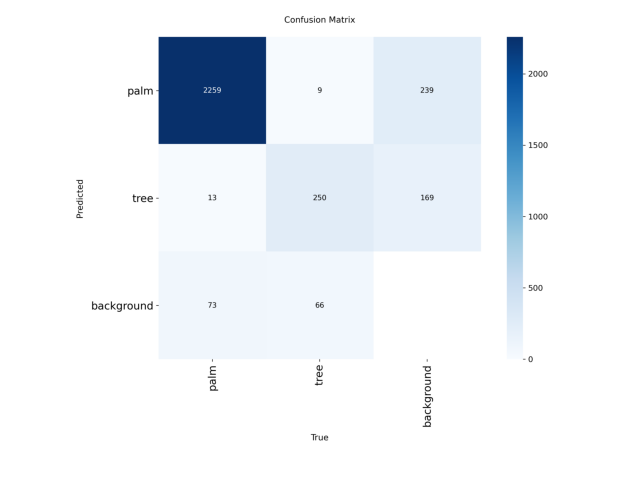

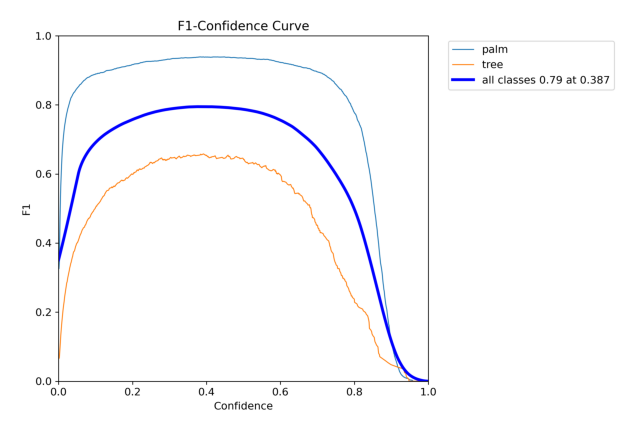

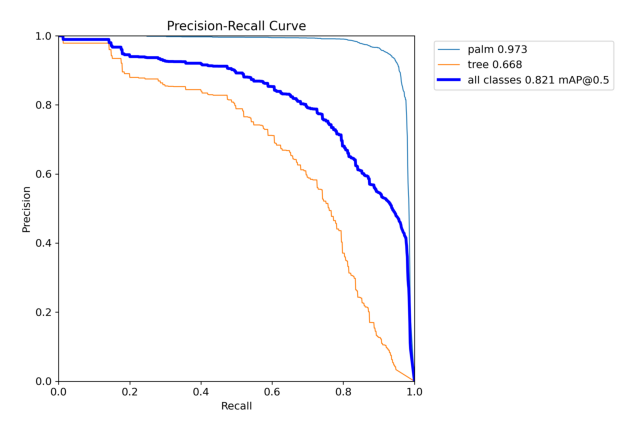

⚠️ File not found: runs/detect/val/labels.jpg
⚠️ File not found: runs/detect/val/results.png


In [30]:
def show_image(path, size=8):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return
    
    img = cv2.imread(path)
    if img is None:
        print(f"Failed to load image: {path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size, size))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
val_dir = "runs/detect/val"

show_image(f"{val_dir}/confusion_matrix.png", size=8)
show_image(f"{val_dir}/F1_curve.png", size=8)
show_image(f"{val_dir}/PR_curve.png", size=8)
show_image(f"{val_dir}/labels.jpg", size=8)  # Will skip if missing
show_image(f"{val_dir}/results.png", size=10)

In [31]:
model.predict(source="yolo_dataset/images/test", save=True, save_txt=True)


image 1/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test/ck2euxc9kxgvm07486g2d5pid.jpg: 480x640 47 palms, 41 trees, 24.2ms
image 2/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test/ck2g7wdv128xl0811szdwargh.jpg: 480x640 105 palms, 23.2ms
image 3/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test/ck2g892277awc0725zbo48h3z.jpg: 480x640 99 palms, 3 trees, 24.3ms
image 4/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test/ck2g8ivqq2flt0811ddim0vch.jpg: 480x640 83 palms, 11 trees, 23.4ms
image 5/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test/ck2gc6eaggd4m0748e86tcwvm.jpg: 480x640 79 palms, 2 trees, 23.4ms
image 6/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test/ck2genyal9n9c0725rwovvd0v.jpg: 480x640 54 palms, 24.4ms
image 7/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test/ck2gewolk9pow0725a4aef2fo.jpg: 480x640 100 palms, 1 tree, 23.4ms
image 8/70 /home/coder/Desktop/DEEP_LEARNING/yolo_dataset/images/test

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'palm', 1: 'tree'}
 obb: None
 orig_img: array([[[102, 101, 105],
         [ 94,  93,  97],
         [ 87,  86,  90],
         ...,
         [204, 211, 206],
         [206, 213, 208],
         [200, 207, 202]],
 
        [[104, 103, 107],
         [ 90,  89,  93],
         [ 78,  77,  81],
         ...,
         [204, 211, 206],
         [206, 213, 208],
         [201, 208, 203]],
 
        [[106, 105, 109],
         [ 91,  90,  94],
         [ 81,  80,  84],
         ...,
         [206, 213, 210],
         [206, 215, 212],
         [202, 211, 208]],
 
        ...,
 
        [[ 80,  81,  65],
         [ 88,  89,  73],
         [ 95,  96,  80],
         ...,
         [218, 224, 229],
         [218, 224, 229],
         [218, 224, 229]],
 
        [[ 82,  83,  67],
         [ 94,  95,  79],
         [102, 103,  87],
         ...,
         

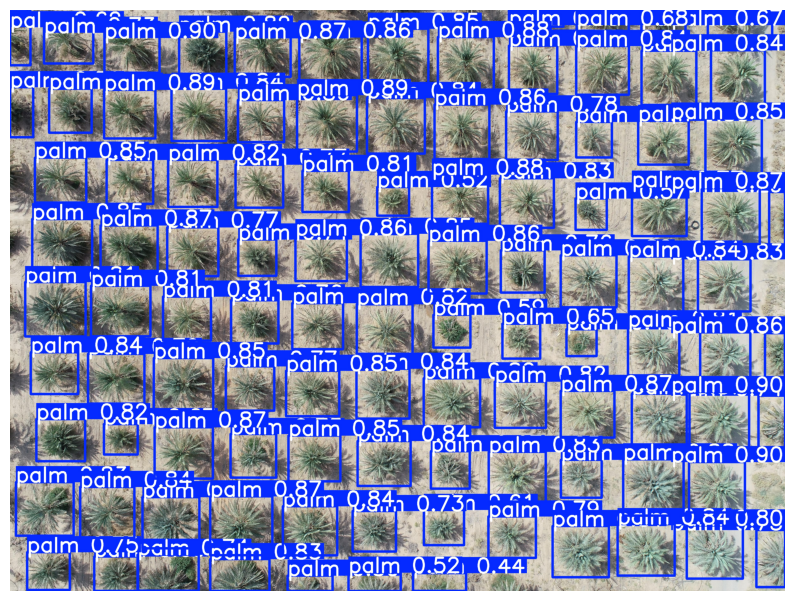

In [33]:
pred_img = "runs/detect/predict/ck2g7wdv128xl0811szdwargh.jpg"
img_bgr = cv2.imread(pred_img)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()